# Preparations

In [ ]:
%config InlineBackend.figure_format ='retina'
%load_ext autoreload
%autoreload 2
%matplotlib inline

In order to visualize tikz code blocks you need to install the [itikz](https://github.com/jbn/itikz) extension with:

    pip install itikz

In [167]:
%load_ext itikz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
import os
import copy
import numpy as np
import msprime
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from IPython.core.display import SVG

In [169]:
import utils

# Lab session: recombination rate estimation using Recurrent Neural Networks

## Aims

In this lab session we will build a Recurrent Neural Network model for estimating recombination rates from sequence variation data. The model is based on the article Predicting the Landscape of Recombination Using Deep Learning *(Adrion et al, 2020)*. ReLERNN estimates recombination rate landscapes directly from genotype alignments expressed as vcf files. We will partly reproduce the network model of ReLERNN.

According to the developers, ReLERNN is accurate even when faced with demographic misspecifications, missing genotypes, and genome inaccessibility. They also claim it performs well at small sample sizes and can also take as input allele frequencies estimated from Pool-seq data.

Recombination rates vary along chromosomes, between chromosomes, between species and more. Importantly, they affect the test stastitics of genome-wide scans for e.g. selection *(Burri et al 2015)*: 

<div><img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4617962/bin/1656f01.jpg" width=500></img>

The F_st peaks could indicate regions undergoing selection, but they could also be caused by the confounding effect of lower nucleotide diversity ($\pi$), which in turn is correlated with recombination rate. Note how the valley for the recombination rate (cM/Mbp) in the lower left panel overlaps the F_st peaks.

For this reason, *(Wolf and Ellegren 2017)* stress the importance of including recombination rate data when performing population genomic analyses.


ReLERNN estimates recombination rates from sequence alignments. Assume that we have a sequence alignment that looks as follows:

<div style="font-family: monospace; font-size: 32pt;">
<table style="font-family: monospace; font-size: 32pt;">
    <tr>
        <td>
            <p style="font-family: monospace;">12345678901234567890123</p>
        </td>
    </tr>
    <tr>
        <td style="font-size: 32pt;">
            AACGT<b>A</b>AGTACCTAGTTAGTGGA
        </td>
    </tr>
    <tr>
        <td>
            AACGTTAGTACC<b>C</b>AGTTAGTGGA
                    </td>
    </tr>
    <tr>
        <td>
            AA<b>T</b>GTTAGTACCTAGTTAGTGGA
                    </td>
    </tr>
    <tr>
        <td>
            AA<b>T</b>GTTAGTACCTAGTTAGTGGA
                    </td>
    </tr>
</table>
</div>
   

 
where segregating (variable) sites are highlighted in boldface. Obviously the monomorphic sites convey no information, so we can focus our attention to the seqregating sites, or genotype alignments, only:

<table style="font-family: 'Lucida Console', monospace; font-size: 20pt">
    <tr>
        <td>
            <p style="font-family:'Lucida Console', monospace">363</p>
        </td>
    </tr>
    <tr>
        <td>
            C<b>A</b>T
        </td>
    </tr>
    <tr>
        <td>
            CT<b>C</b>
                    </td>
    </tr>
    <tr>
        <td>
            <b>T</b>TT
                    </td>
    </tr>
    <tr>
        <td>
            <b>T</b>TT
                    </td>
    </tr>
    </table>
    

However, the *distance* between sites matters - the larger it is, the greater the probability of a recombination event - so we need to keep track of positions too. Hence, we need a method to simulate sequences with a shared common ancestry, where the resulting alignments constitute our data. Any given sequence data set is simulated under a known recombination rate $r$, which serves as the *target* during training. 
    

The method that we will look at uses coalescent simulations to generate data. The data needs to be preprocessed prior to training, and a substantial part of this lab will therefore be devoted to data preparation. Once data is in an appopriate format, we turn to modelling. Briefly then, the aims of this lab are:

1. to familiarize yourself with the coalescent simulator msprime
2. to preprocess the data
3. to familiarize yourself with the code for producing data inputs in sequence batches
4. to train and apply the model to some toy examples

If time permits, there are some additional suggestions at the end, including testing the software package ReLERNN itself.

## Mini-introduction to msprime

As we will use msprime (https://msprime.readthedocs.io/en/stable/index.html) to simulate both observed data, as well as training and test data, we here provide a mini-introduction to the few commands that are required.

The basic idea of the coalescent process is to relate a set of individuals, or sequences, to oneother through a genealogy, looking *backwards* in time. The genealogy is built iteratively by sampling two sequences to have a common ancestor and to merge those lineages at a time in the past. The distance to that past event is drawn from an Exponential distribution with rate proportional to the number of individuals currently alive. The process is repeated until only one individual remains.

Once the genealogy has been generated, mutations are added following a Poisson process by sprinkling them on the genealogy. The probability that a mutation ends up on a particular branch is proportional to the branch length with respect to the total tree length. The independence of the genealogy and mutation process is a consequence of the assumption that mutations are selectively *neutral*. Thus, the independence does not hold for loci being selected upon.

To begin with, we show the command for simulating a small sample (n=6) of 1kb sequences from a population with a diploid effective population size 1000 ($N_e$=1000). The effective population size $N_e$ is a somewhat abstract population genetic measure that is often smaller than the census population size $N$; see https://en.wikipedia.org/wiki/Effective_population_size for a longer discussion. We also print a representation of the tree:

In [71]:
import msprime
tree_sequence = msprime.sim_ancestry(samples=3, population_size=1000, sequence_length=1e4, random_seed=42)
tree = tree_sequence.first()
print(tree.draw(format="unicode"))

     10    
    ┏━┻━━┓ 
    9    ┃ 
  ┏━┻━┓  ┃ 
  8   ┃  ┃ 
 ┏┻━┓ ┃  ┃ 
 ┃  ┃ ┃  7 
 ┃  ┃ ┃ ┏┻┓
 6  ┃ ┃ ┃ ┃
┏┻┓ ┃ ┃ ┃ ┃
0 1 4 5 2 3



We can also display the tree in svg format as it allows to show the branch lengths and where mutations occur on the tree, and also to draw all tree sequences simultaneously:

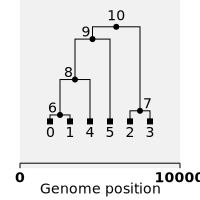

In [72]:
display(SVG(tree_sequence.draw_svg()))

The `tree_sequence` object is a so-called succinct (compact) data structure representation of trees along the sequence, based on the fact that neighbouring genomic regions have correlated genealogical histories. The interested reader can consult the tskit documentation (https://tskit.readthedocs.io/en/latest/data-model.html?highlight=succinct#definitions) for more information. As the name implies, it consists of a sequence of trees, where a tree represents a part of the sequence that has a given genealogy. Since we have no recombination events, there should only be one tree:

In [73]:
len(list(tree_sequence.trees()))

1

Recombination events are added via the `recombination_rate` parameter:

In [97]:
tree_sequence_rec = msprime.sim_ancestry(samples=3, population_size=1000, sequence_length=1e4, random_seed=46, recombination_rate=2e-8)

Now, because of recombination, different parts of the sequence will have different histories, or genealogies. To understand this, consider the following situation for a **non**-recombining chromosome. The picture below shows 


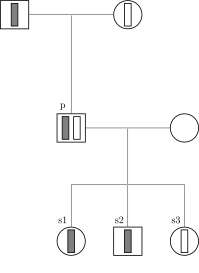

In [191]:
%%itikz
\documentclass[tikz]{standalone}
\begin{document}
\begin{tikzpicture}
% [>=latex,font=\sffamily\small, thick]
\tikzset{plab/.style={font=\scriptsize, outer sep=0cm}}
\tikzset{female/.style={circle,thick,minimum size=1cm,draw=black}}
\tikzset{male/.style={rectangle,thick,minimum width=1cm, minimum height=1cm, draw=black}}
\tikzset{chrom/.style={rectangle,thick,minimum width=0.2cm, minimum height=0.8cm, draw=black}}

\node[male] (grandfather) at (0, 8) { };
\node[chrom, fill=gray] (grandfather_pchrom) at (0, 8) {};
\node[female] (grandmother) at (4, 8) { };
\node[chrom] (grandfather_mchrom) at (4, 8) {};

\node[inner sep=0cm] (grandparents) at (2, 8) { };

\node[male, label={[shift={(-0.3,0)}]p}] (father) at (2, 4) { };
\node[chrom, fill=gray] (father_pchrom) at (1.8, 4) {};
\node[chrom] (father_mchrom) at (2.2, 4) {};
\node[female] (mother) at (6, 4) { };

\node[inner sep=0cm] (parents) at (4, 4) { };
\node[inner sep=0cm] (siblings) at (4, 2) { };

\node[female, label={[shift={(-0.3,0)}]s1}] (s1) at (2, 0) {  };
\node[chrom, fill=gray] (s1_pchrom) at (2, 0) {};
\node[male, label={[shift={(-0.3,0)}]s2}] (s2) at (4, 0) {  };
\node[chrom, fill=gray] (s2_pchrom) at (4, 0) {};
\node[female, label={[shift={(-0.3,0)}]s3}] (s3) at (6, 0) { };
\node[chrom] (s3_pchrom) at (6, 0) {};

\draw (grandfather) -- (grandmother);
\draw (grandparents) -- (father);
\draw (parents) -- (siblings);
\draw (father) -- (mother);
\draw (siblings) -| (s1);
\draw (siblings) -| (s2);
\draw (siblings) -| (s3);
\node (dummy) at (0, -1) {};
\end{tikzpicture}
\end{document}

Consequently, we have several trees along the sequence:

In [98]:
len(list(tree_sequence_rec.trees()))

4

where the lengths of the non-recombining segments and the genealogies of the segments can be obtained as follows:

In [99]:
for tree in tree_sequence_rec.trees():
...     print("-" * 20)
...     print("tree {}: interval = {}".format(tree.index, tree.interval))
...     print(tree.draw(format="unicode"))

--------------------
tree 0: interval = Interval(left=0.0, right=3981.0)
  13       
┏━━┻━━┓    
┃    10    
┃   ┏━┻━━┓ 
┃   ┃    9 
┃   ┃   ┏┻┓
┃   8   ┃ ┃
┃  ┏┻━┓ ┃ ┃
┃  6  ┃ ┃ ┃
┃ ┏┻┓ ┃ ┃ ┃
0 1 2 4 3 5

--------------------
tree 1: interval = Interval(left=3981.0, right=7904.0)
  12       
┏━━┻━━┓    
┃    10    
┃   ┏━┻━━┓ 
┃   ┃    9 
┃   ┃   ┏┻┓
┃   8   ┃ ┃
┃  ┏┻━┓ ┃ ┃
┃  6  ┃ ┃ ┃
┃ ┏┻┓ ┃ ┃ ┃
0 1 2 4 3 5

--------------------
tree 2: interval = Interval(left=7904.0, right=9801.0)
   12      
 ┏━━┻━━━┓  
 ┃     10  
 ┃    ┏━┻━┓
 ┃    8   ┃
 ┃   ┏┻━┓ ┃
 7   ┃  ┃ ┃
┏┻┓  ┃  ┃ ┃
┃ ┃  6  ┃ ┃
┃ ┃ ┏┻┓ ┃ ┃
0 3 1 2 4 5

--------------------
tree 3: interval = Interval(left=9801.0, right=10000.0)
   11      
 ┏━━┻━━━┓  
 ┃     10  
 ┃    ┏━┻━┓
 ┃    8   ┃
 ┃   ┏┻━┓ ┃
 7   ┃  ┃ ┃
┏┻┓  ┃  ┃ ┃
┃ ┃  6  ┃ ┃
┃ ┃ ┏┻┓ ┃ ┃
0 3 1 2 4 5



Plotted in svg format, we see the tree sequence along the sequence:


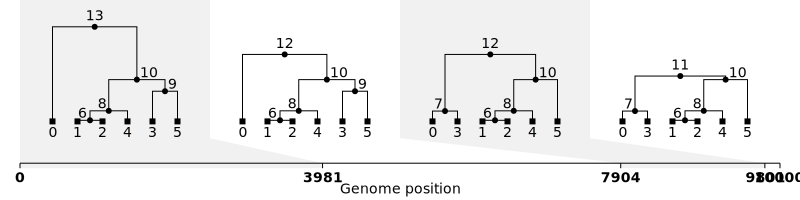

In [82]:
display(SVG(tree_sequence_rec.draw_svg()))

If you study the sequence of trees, you see that they change along the sequence, reflecting the fact that they due to recombination have separate histories. Note also that neighbouring trees are correlated, that is, they have similar topologies. One can transform a tree to a neigbouring tree via simple subtree prune and regraft operations. This observation may seem to indicate that the trees are Markovian, i.e. the state of a tree only depends on its predecessor. That is not strictly true however as there are more long-range correlations. However, this assumption is often made in so-called Sequentially Markovian Coalescent models, on which for instance PSMC and MSMC are based.

This means that if we could infer genealogies along a sequence, we could also infer the recombination break points. However, as we do not observe genealogies, but rather sequence alignments (of the leaves of the tree), in order to infer genealogies, we need sequence variation, or mutations. Mutations are added by applying the `mutation_rate` parameter:

In [92]:
tree_sequence_mut = msprime.mutate(tree_sequence, rate=1e-7, random_seed=4)
tree = tree_sequence_mut.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation @ position {:.2f} over node {}".format(site.position, mutation.node))

Mutation @ position 62.30 over node 5
Mutation @ position 5472.32 over node 0
Mutation @ position 6329.63 over node 7
Mutation @ position 7148.16 over node 1


We can illustrate where the mutations occur by plotting the tree in svg format:

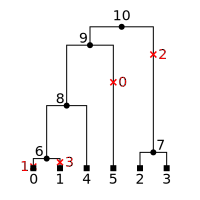

In [93]:
display(SVG(tree.draw_svg()))

The leaves correspond to sequences that we observe. Here, sequences 2 and 3 will share one mutations (number 2), sequence 0 has one mutations (1), sequence 1 one mutation (3), sequence 5 one mutation (0) and sequence 4 no mutations. We can print the sequences by using the `genotype_matrix` function:

In [95]:
tree_sequence_mut.genotype_matrix()

array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=int8)

Here, the rows correspond to sites (mutations) and columns to samples; sample 0 has sequence `0100`, sample 1 `0001` and so on. Sequence sites are binary coded, where 0 is an ancestral state and 1 is a derived state (mutation). 

Now we combine mutation and recombination and plot the entire tree sequence, as a final visualization of the simulated data.

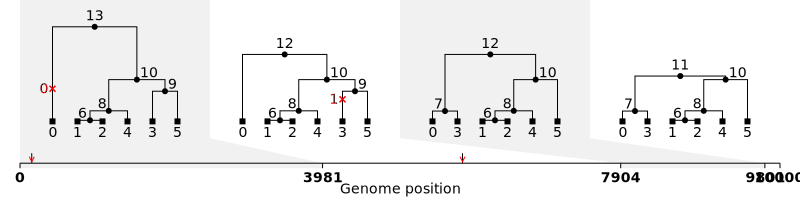

In [100]:
tree_sequence_rec_mut = msprime.mutate(tree_sequence_rec, rate=2e-8, random_seed=32)
display(SVG(tree_sequence_rec_mut.draw_svg()))

Note that the mutations are now indicated on the genome position coordinate axis. As in the previous example, a mutation is also displayed in the corresponding tree for a non-recombining block, such that mutation 0 occurs in individual 0, and mutation 1 in individual 3.

Modify the mutation rate and recombination rate a couple of times to make sure you understand how they affect the final output. Also, write down the sequences for some of the leaves (in particular number 4) to make sure you understand how mutations propagate through the tree. Compare your results with the output of `tree_sequence.genotype_matrix()`.

# Simulating data with flat recombination rate

Now that we have tested msprime, let's use it to simulate data. The data will need to be preprocessed prior to modelling, and we will look at the preprocessing steps by first looking at one simulated data set.

For demonstration purposes, we first simulate a small set of sequences generated by a process with a flat recombination rate. We simulate 1kb sequences, sample size $n=5$ from a population with effective population size $N_e=1000$. We choose small values for population size and sequence length to speed up simulations, but must then increase the mutation rate in order to obtain observable events. 

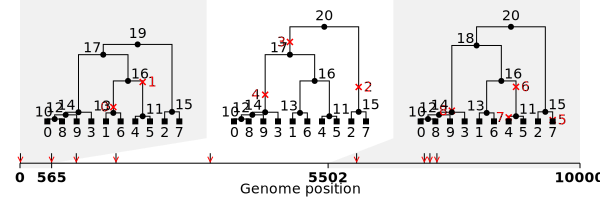

CPU times: user 20.9 ms, sys: 462 µs, total: 21.4 ms
Wall time: 20.6 ms


In [112]:
%%time
sample_size = 5
obs1 = msprime.sim_ancestry(samples=sample_size, population_size=1000, sequence_length=1e4, random_seed=42, recombination_rate=1e-8)
obs1 = msprime.mutate(obs1, rate=1e-7, random_seed=42)
display(SVG(obs1.draw_svg()))

We print the number of sites and nucleotide diversity ($\pi$) for the observed data:

In [113]:
(obs1.get_num_sites(), obs1.diversity())

(9, array(0.00032444))

and make two plots of the data. First, for illustration purposes, we plot the entire sequence alignment. However, since the tree sequences only store segregating sites, we need to pad the genotypes with monomorphic sites. We use a helper function `utils.fill_pad` for this purpose; the `utils` module (living in the notebook directory) contains more utility functions that will be used later on. 

[7219, 7319, 7444]


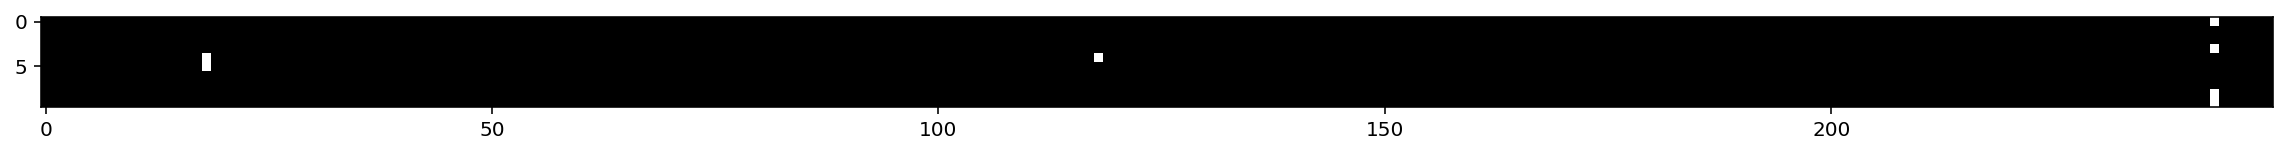

In [126]:
x = utils.fill_pad(obs1.genotype_matrix(), np.array([s.position for s in obs1.sites()]), 10000)
plt.figure(figsize = (20,20))
p = plt.imshow(x[7200:7450, :].T, cmap='gray')
print([int(s.position) for s in obs1.sites()][6:9])

Here we plot positions 7200-7450 (x-axis; tick labels refer to indices in the array slice, not sequence position). The samples are on the y axis (note that we have transposed the sequence matrix with the `T` function!). Black pixels indicate monomorphic sites, white segregating sites that occupy sequence positions 7219, 7319, and 7444.

Second, for comparison we plot the unpadded genotype matrix:

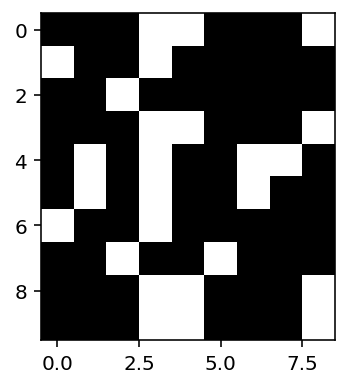

In [127]:
plt.figure(figsize = (10,3))
p = plt.imshow(obs1.genotype_matrix().T, cmap='gray')

Looking from right to left, we see that the three last columns correspond to the positions 7219, 7319, and 7444.

The data we present to the model consists of the genotype matrices as monomorphic positions offer no additional information. Sequence *positions* do however - the farther apart two loci are, the greater the probability of a recombination event in between them - so in addition to the genotypes, we need to keep track of the positions. Hence, the input data will consist of:

1. genotype data
2. positional information
3. a known recombination rate that was use to simulate the data (our training "target")

## Data preprocessing

The data still needs to be preprocessed. The following steps are performed in ReLERNN; we will apply a select number (but should you be in a groove you are free to implement them all!):

1. the genotype matrix is padded with value -1.0 so that all examples are of equal size
2. likewise, the position vector is padded with 0
3. samples are shuffled and haplotypes sorted by similarity
4. the alignment is padded by a frame (after shuffling)
5. the recombination rates are z-score normalized

### Data padding

Input data needs to be of equal lengths. Once we simulate data, we will keep track of the maximum number of segregating sites observed. Assume for now this is 30; we use `utils.pad` to pad our genotype matrix:


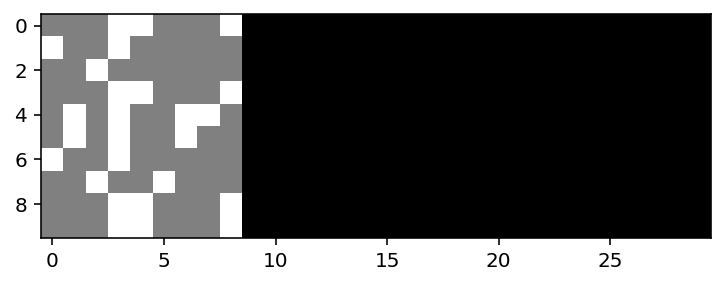

In [128]:
x, pos = utils.pad(obs1.genotype_matrix(), [s.position for s in obs1.sites()], maxsites=30)
p = plt.imshow(x.T, cmap='gray')

Since we added a new value (-1, black pixels), ancestral sites show up as gray.

As stated above, ReLERNN also adds a padding frame of width 5, which we show for illustration purposes (we will not use it later on):

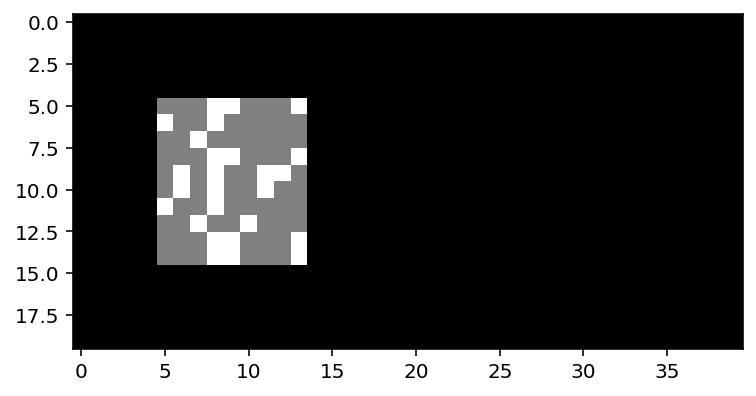

In [129]:
x, pos = utils.pad(obs1.genotype_matrix(), [s.position for s in obs1.sites()], maxsites=30, frameWidth=5)
p = plt.imshow(x.T, cmap='gray')

With this demonstration of some of the data preprocessing steps, we are now ready to simulate our data!

## Simulation of training, validation, and test data

The ReLERNN example pipeline simulates 100000 training, 1000 test and 2000 validation data sets. For practical reasons we here reduce these data set sizes somewhat. In general, we want to vary the mutation and recombination rates to generate data sets with different parametrizations. We therefore write a wrapper function to generate simulations and save the results. The function is also available in the `utils` module:

In [132]:
def simulate(nreps, outdir, seed=42, murange=(0, 2e-7), rhorange=(0, 2e-7), sample_size=5, Ne=1e4, length=1e4, **kwargs):
    """Simulate tree sequences with msprime and save genotype matrix and positions to outdir"""
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    mu = [np.random.uniform(murange[0], murange[1]) for _ in range(nreps)]
    rho = [np.random.uniform(rhorange[0], rhorange[1]) for _ in range(nreps)]
    S = np.empty(nreps, dtype="int64")
    for i in range(nreps):
        ts = msprime.sim_ancestry(random_seed=seed, samples=sample_size, population_size=Ne, sequence_length=length,
                                  recombination_rate=rho[i], **kwargs)
        ts = msprime.mutate(ts, rate=mu[i])
        np.save(os.path.join(outdir, f"{i}_haps.npy"), ts.genotype_matrix())
        np.save(os.path.join(outdir, f"{i}_pos.npy"), np.array([s.position for s in ts.sites()], dtype="float32"))
        S[i] = ts.get_num_sites()
    info = {'mu': mu, 'rho': rho, 'S': S, 'nreps': nreps, 'dataset': outdir,
            'sample_size': sample_size, 'Ne': Ne, 'length': length}
    with open(os.path.join(outdir, "info.p"), "wb") as fh:
        pickle.dump(info, fh)

The function generates random values with `np.random.uniform` for mutation rate $\mu$ and recombination rate $\rho$, and then iterates `nreps` times to call msprime with different parameter values, saving the results in the directory pointed to by `outdir`.

Now, let's simulate some data sets - 11100 in total. This will likely take less than two minutes!

In [133]:
%%time
# On my laptop (3.1GHz Dual-core intel i7) it takes approx 1s per 200 samples, total space ~ 125Mb
assumedMu = 1e-8
upperRhoThetaRatio = 1.0
murange = (0.66*assumedMu, 1.33*assumedMu) # Constrain mu values
rhorange = (0.0, assumedMu * upperRhoThetaRatio) # constrain upper value of rho
params = {'murange': murange, 'rhorange': rhorange, 'length': 1e5, 'sample_size': 10, 'Ne': 40000}
simulate(10000, "train", **params)
simulate(100, "test", **params)
simulate(1000, "vali", **params)

CPU times: user 57.1 s, sys: 640 ms, total: 57.7 s
Wall time: 57.7 s


We read and extract relevant info from the pickled information files `info.p` for each data set and summarize stats for a sanity check. Since we have $n=10$ samples, effective population size $N_e=40000$ and simulate $L=10000$ bp sequences, we expect $E(S) = 4 * N_e * \mu * a * L$ number of segregating sites, where $a=\sum_{i=1}^{n-1}\frac{1}{i}$ (see e.g. https://en.wikipedia.org/wiki/Watterson_estimator).

In [134]:
traininfo = pickle.load(open(os.path.join("train", "info.p"), "rb"))
valiinfo = pickle.load(open(os.path.join("vali", "info.p"), "rb"))
testinfo = pickle.load(open(os.path.join("test", "info.p"), "rb"))
data = pd.DataFrame({})
for k in ['S', 'rho', 'mu']:
    data[k] = np.concatenate((traininfo[k], valiinfo[k], testinfo[k]))
i = np.arange(1, traininfo["sample_size"])
a = sum(1/i)
data["Sexp"] = a * 4 * traininfo["Ne"] * data.mu * traininfo["length"]  # theta = E(pi) = S/a = 4*Ne*mu

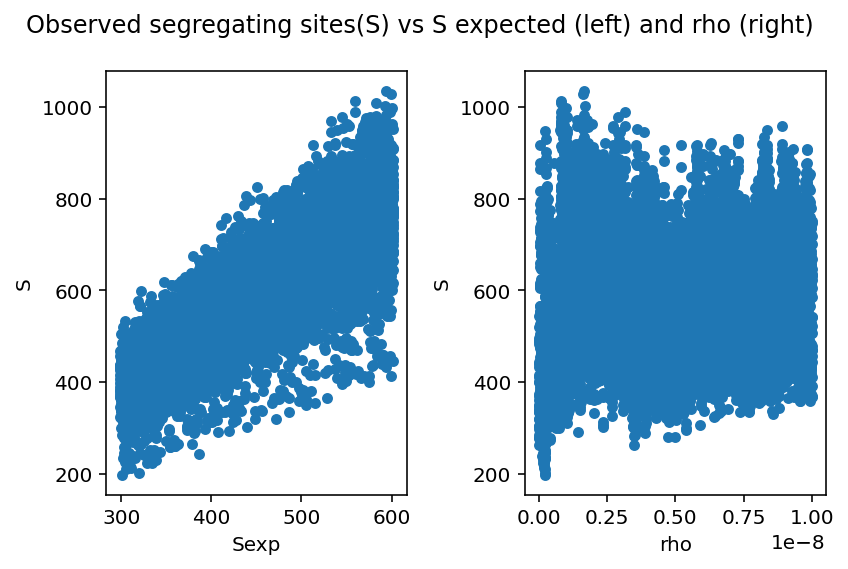

In [135]:
fig, axes = plt.subplots(nrows=1,ncols=2)
data.plot.scatter(x="Sexp", y="S", ax = axes[0], subplots=True, 
                  title="Observed segregating sites(S) vs S expected (left) and rho (right) ") 
data.plot.scatter(x="rho", y="S", ax = axes[1], subplots=True)
fig.tight_layout()
plt.show()

The left plot shows the observed versus expected number of segregating sites, where the large variance of $S$ is visible. The right plot shows $S$ as a function of $\rho$, and one would like to see a large sampling of $S$ for all $\rho$ values.

## Sequence generators for training

Even with this toy example, there may be memory issues when loading all training data. Therefore, it is better to generate data on the fly and provide it in batches during training. We use the `tf.keras.utils.Sequence` base class to achieve this purpose. See https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly for a concise treatment of this topic.

We here present the code in pieces. The subclass is available as `utils.sequenceBatchGenerator`.

First, we setup a generator object and initialize some settings with `__init__`. The `on_epoch_end` is run at the end of an epoch, and here one typically shuffles the order of the data presented to the network. The functions `__len__` and `__getitem__` **must** be implemented. `normalizeRho` converts target recombination rates to Z-scores.

In [136]:
def __init__(self, datadir, maxlen, batchSize=16, frameWidth=0, seed=None):
    self.datadir = datadir
    self.info = pickle.load(open(os.path.join(datadir, "info.p"), "rb"))
    self.n_data = self.info["nreps"]
    self.maxlen = maxlen
    self.batchSize = batchSize
    self.frameWidth = frameWidth
    self.rhoZ = self.normalizeRho()
    self.on_epoch_end()

def on_epoch_end(self):
    """Shuffle indices to randomize order of training examples on epoch end"""
    self.indices = np.arange(self.n_data)
    np.random.shuffle(self.indices)
    
def normalizeRho(self):
    """Convert rho to Z-scores"""
    rhoZ = copy.deepcopy(self.info["rho"])
    rho_mean = np.mean(rhoZ, axis=0)
    rho_sd = np.std(rhoZ, axis=0)
    rhoZ -= rho_mean
    rhoZ = np.divide(rhoZ, rho_sd, out=np.zeros_like(rhoZ),
                     where=rho_sd != 0)
    return rhoZ

def __len__(self): # must be implemented
    """Get the number of batches per epoch as the number of data points divided by batch size"""
    return int(np.floor(self.n_data / self.batchSize))

def __getitem__(self, index): # must be implemented
    """Generate data indices for a given batch index (where index <= len(self))"""
    batchIndices = self.indices[index * self.batchSize: (index+1) * self.batchSize]
    X, y = self.__data_generation(batchIndices)
    return X, y

The actual data generation is done by the `__data_generation` function, which we present here:

In [137]:
def __data_generation(self, batchIndices):
    """Required core function to generate data batch"""
    haps = []
    pos = []
    # Read one dataset at a time
    for i in batchIndices:
        H = np.load(os.path.join(self.datadir, f"{i}_haps.npy"))
        P = np.load(os.path.join(self.datadir, f"{i}_pos.npy"))
        P = P / self.info["length"]
        # Add shuffling of individuals, reorganization of
        # haplotypes takes place here
        hpad, ppad = pad(H, P, self.maxlen, frameWidth=self.frameWidth)
        haps.append(hpad)
        pos.append(ppad)
    haps = np.array(haps, dtype="float32") # (batchSize, nSites, nsamples)
    pos = np.array(pos, dtype="float32") # (batchSize, nSites)
    rhoZ = [[t] for t in self.rhoZ[batchIndices]]
    return [haps, pos], np.array(rhoZ) # X, y

We load `batchSize` data sets, where the `batchIndices` have been selected in the `__getitem__` method. The data sets are padded before we return them. Note that here we could do additional preprocessing, such as shuffling individuals.

That's actually all that is needed! We can now define three sequence batch generators for the data sets:

In [138]:
frameWidth = 0
Smax = max(data["S"])
train_sequence = utils.sequenceBatchGenerator("train", Smax, frameWidth=frameWidth)
test_sequence = utils.sequenceBatchGenerator("test", Smax, frameWidth=frameWidth)
vali_sequence = utils.sequenceBatchGenerator("vali", Smax, frameWidth=frameWidth)

## Model definition

Now that we have gone through the painstaking endeavours that data mangling and preprocessing present, we are ready to start modelling. This will actually require less coding than until now. 

We begin by writing a wrapper function for our model, which is slightly modified from the version by Adrion et al, whose model looks like this:

<img src="relernn_network.png" width="300"></img>

The model utilizes Gater Recurrent Units (GRUs) that excel at identifying temporal associations. Here, 'time' is sequence position. A GRU can identify long-range associations, and whereas traditional methods look at two-allele linkage disequilibrium, it is possible that this architecture also leverages information from three-locus and four-locus linkage disequilibrium.

In [160]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Modelled on ReLERNN.networks.GRU_TUNED84
def GRU(x, y):
    haps, pos = x
    nsites = haps[0].shape[0]
    nsamples = haps[0].shape[1]
    npos = pos[0].shape[0]

    # Define input layer that takes a genotype matrix; recall that genotype matrix stores data as (nsites, nsamples)
    genotype_inputs = layers.Input(shape=(numSnps, 2 * sample_size))
    # analyze sequences in both directions, GRU more computationally efficient than LSTM
    model = layers.Bidirectional(layers.GRU(84, return_sequences=False))(genotype_inputs)
    # Add dense layer with 256 neurons in output space
    model = layers.Dense(256)(model)

    # Define input layer for positions
    position_inputs = layers.Input(shape=(npos,))
    m2 = layers.Dense(256)(position_inputs)

    # Concatenate genotype matrix and position input layers
    model = layers.concatenate([model, m2])
    # Add Dense and output layer that outputs a (normalized) recombination value
    model = layers.Dense(64)(model)
    output = layers.Dense(1)(model)

    model = Model(inputs=[genotype_inputs, position_inputs], outputs=[output])
    model.compile(optimizer="Adam", loss="mse")
    models.summary()
    return model

Briefly, genotype inputs are fed to a bidirectional Gated Recurrent Unit which are then fed to a dense layer. Positional inputs are fed to a dense layer, the two layers are concatenated and finally output as a scalar value reperesenting recombination rate. We access the function as `utils.GRU` and define a model:


In [161]:
# Need x and y to determine network topology details
x, y = train_sequence[0]
model = utils.GRU(x, y)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1035, 20)]   0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 168)          53424       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1035)]       0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          43264       bidirectional_2[0][0]            
____________________________________________________________________________________________

## Model fitting


We now fit our model. Depending on time, you may have to adjust the parameters. On my laptop, with 10 `steps_per_epoch` it takes approximately 30s per epoch. The authors state that they run 200+ epochs, which obviously is outside the scope of this exercise. 

This concludes the part of the exercise with prepared code. While you're waiting for the training to finish, skip to the next section where you have a number of suggestions of additional exercises.

In [162]:
%%time
history = model.fit(train_sequence, steps_per_epoch=10, epochs=100, validation_data=vali_sequence)

Epoch 1/100
10/10 [==============================] - 2s 140ms/step - loss: 7.1882 - val_loss: 4.7621
Epoch 2/100
10/10 [==============================] - 1s 109ms/step - loss: 2.0017 - val_loss: 1.0731
Epoch 3/100
10/10 [==============================] - 1s 110ms/step - loss: 1.1534 - val_loss: 0.9930
Epoch 4/100
10/10 [==============================] - 1s 118ms/step - loss: 1.0366 - val_loss: 1.0035
Epoch 5/100
10/10 [==============================] - 1s 120ms/step - loss: 0.9885 - val_loss: 1.0001
Epoch 6/100
10/10 [==============================] - 1s 120ms/step - loss: 1.0188 - val_loss: 0.9700
Epoch 7/100
10/10 [==============================] - 1s 120ms/step - loss: 0.9817 - val_loss: 0.9612
Epoch 8/100
10/10 [==============================] - 1s 118ms/step - loss: 0.9317 - val_loss: 0.9650
Epoch 9/100
10/10 [==============================] - 1s 117ms/step - loss: 0.9438 - val_loss: 0.9312
Epoch 10/100
10/10 [==============================] - 1s 117ms/step - loss: 0.8926 - val_lo

10/10 [==============================] - 1s 124ms/step - loss: 0.0334 - val_loss: 0.0342
Epoch 82/100
10/10 [==============================] - 1s 129ms/step - loss: 0.0357 - val_loss: 0.0469
Epoch 83/100
10/10 [==============================] - 1s 124ms/step - loss: 0.0356 - val_loss: 0.0342
Epoch 84/100
10/10 [==============================] - 1s 124ms/step - loss: 0.0437 - val_loss: 0.0305
Epoch 85/100
10/10 [==============================] - 1s 124ms/step - loss: 0.0388 - val_loss: 0.0295
Epoch 86/100
10/10 [==============================] - 1s 124ms/step - loss: 0.0337 - val_loss: 0.0347
Epoch 87/100
10/10 [==============================] - 1s 131ms/step - loss: 0.0304 - val_loss: 0.0276
Epoch 88/100
10/10 [==============================] - 1s 124ms/step - loss: 0.0306 - val_loss: 0.0272
Epoch 89/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0336 - val_loss: 0.0295
Epoch 90/100
10/10 [==============================] - 1s 128ms/step - loss: 0.0303 - val_loss: 

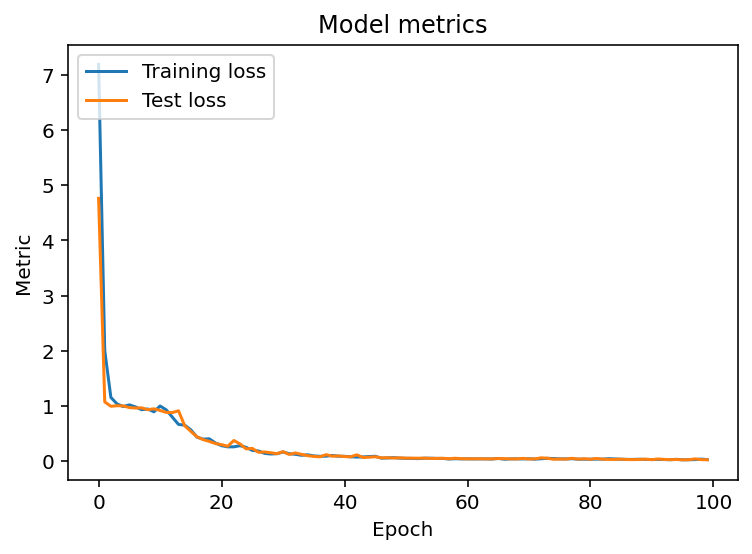

In [163]:
utils.plot_history(history)

Although it would seem no improvements are made after only a couple of epochs, this is an artefact of the axis limits:

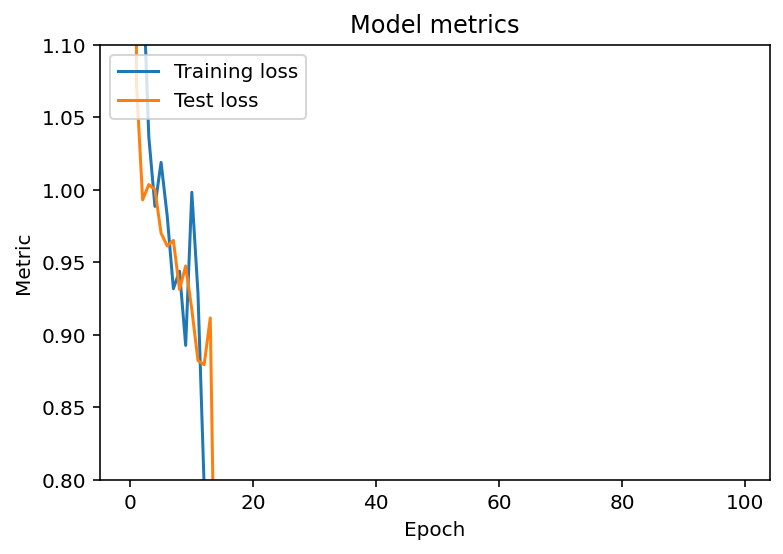

In [164]:
utils.plot_history(history, ylim=(0.8,1.1))

Finally, we predict some values and plot them against the truth:

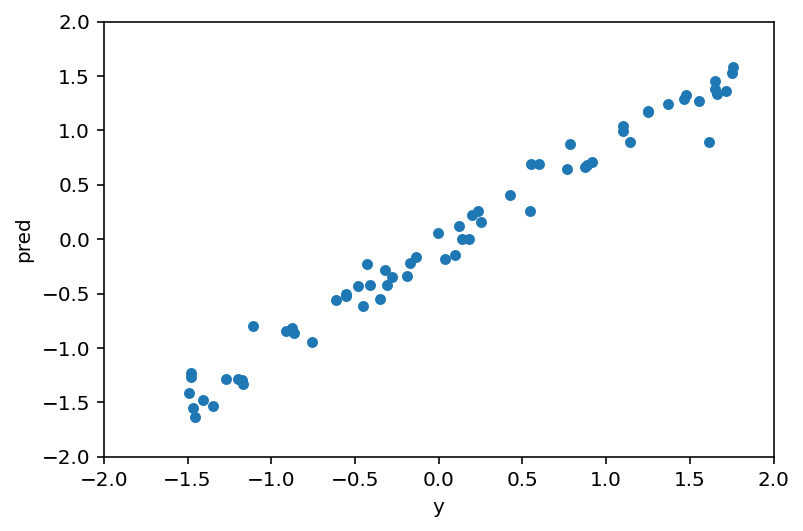

In [165]:
x, y = test_sequence[0]
pred = pd.DataFrame({'y': np.ndarray.flatten(y), 'pred': np.ndarray.flatten(model.predict(x))})
ax = pred.plot.scatter(x="y", y="pred")
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
plt.show()

This is pretty bad, and clearly we need to run more epochs to achieve accurate predictions.

Since you probably don't have time to run any more training epochs, I have prepared a model that has run for 200 epochs in the `models` subdirectory. You can load the model like this:

In [155]:
from tensorflow.keras.models import load_model
m1 = load_model("models/m1.gru.h5")
h1 = pickle.load(open("models/gru.history.p", "rb"))

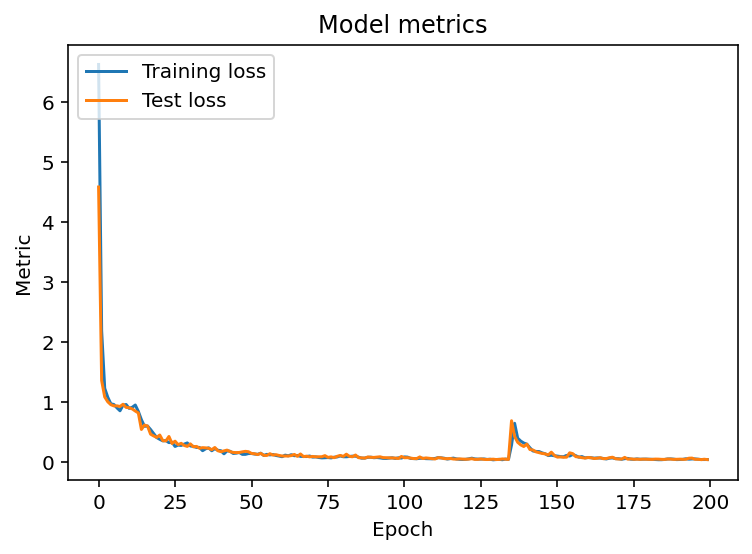

In [156]:
utils.plot_history(h1)

Let's see how this model performs on the test data set. Since this model was trained on a different, larger set of training data, the padding needs to adjusted to the fact that Smax was larger for this data set (Smax=1051).

In [157]:
m1_test_sequence = utils.sequenceBatchGenerator("test", 1051, frameWidth=frameWidth)

In [158]:
x, y = m1_test_sequence[0]
pred = pd.DataFrame({'y': np.ndarray.flatten(y), 'pred': np.ndarray.flatten(m1.predict(x))})
ax = pred.plot.scatter(x="y", y="pred")
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
plt.show()

ValueError: in user code:

    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/peru/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras/engine/input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 1051, 10), found shape=(32, 1051, 20)


# Additional exercises

If you have time over, here are some suggestions on other things to look at. Note that the intention is *not* that you do all of it, but rather choose some topic of your liking. Feel free to explore and adjust the scenarios any way you wish. Please note that not all of these example exercises have been tested thoroughly and that there therefore may be some bumps along the road.

You can still use the model from the previous section even though in reality the simulations should be adjusted to cater for the conditions below. Until now we have just classified one window at a time, but we are interested in recombination landscapes. Since these types of analyses are window-based, we here apply our model to longer test data which we split into windows as input to the network.

Finally, there is an additional model in the `models` directory that implements dropout layers to prevent overfitting. Test this model where you deem appropriate.

## Reimplement network with LSTM architecture

ReLERNN uses a Gated Recurrent Unit architecture. Write a model generating function similar to `utils.GRU` to use Long Short-Term Memory architecture instead.

## Recombination hotspot


Simulate a test data set with a recombination hotspot and see if you can model it. ReLERNN has special functionality to identify hotspots and breakpoints. Here we just emulate a hotspot by using the https://msprime.readthedocs.io/en/stable/api.html#msprime.RecombinationMap class. Adjust the settings to look at different cases.

In [77]:
positions = [0, 4e5, 5e5, 1e6]
rates = [1e-10, 1e-7, 1e-10, 0]
recmap = msprime.RecombinationMap(positions, rates)

In [78]:
x = np.repeat(positions, 2)[1:-1]
y = np.repeat(rates, 2)[:-2]

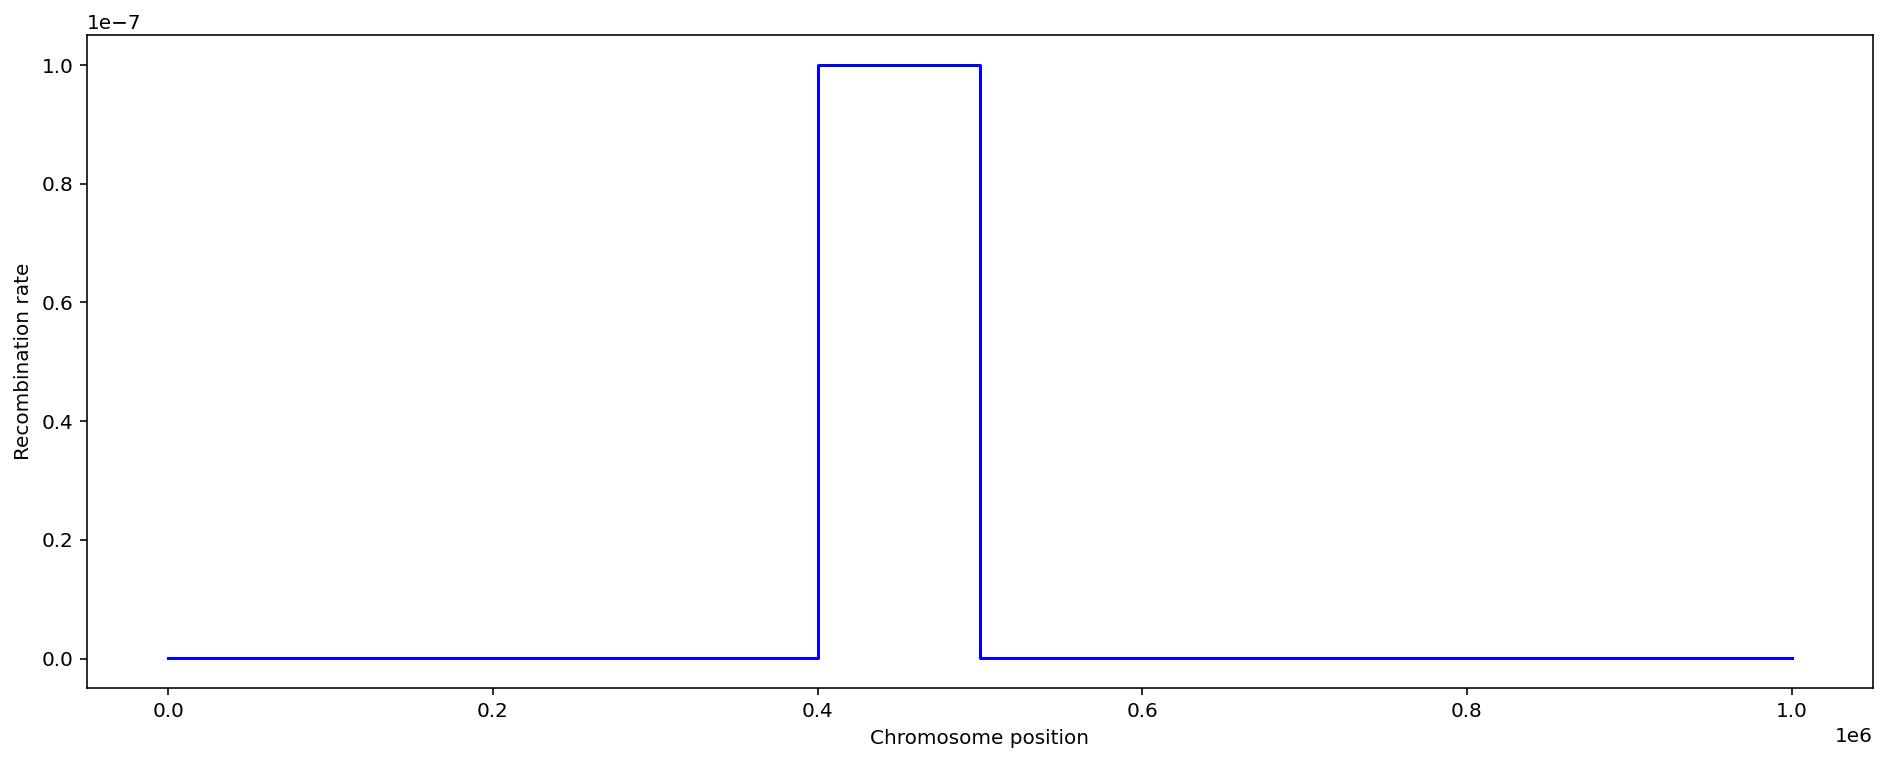

In [79]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(x, y, color="blue")
ax.set_ylabel("Recombination rate")
ax.set_xlabel("Chromosome position")
plt.show()

The `utils.simulate` function will not work for this exercise as you cannot simultaneously specify the recombination rate and a recombination map. Therefore, simulate directly using the `msprime.simulate` function. Try modifying the mutation rate a couple of times to see how it affects the results. 

In [150]:
assumedMu = 2e-8
params = {'mutation_rate': assumedMu, 'sample_size': 10,
          'Ne': 40000, 'recombination_map': recmap}
ts = msprime.simulate(**params)

The idea then is to split the genotype matrix into windows and use the model to predict the recombination rates and plot the results. There is a utility function in `utils` for this purpose. Here is some example code:

In [153]:
windows = np.arange(0, 1e6, 1e4)
g = utils.windowedGenotypeMatrixGenerator(ts, batchSize=len(windows), windows=windows, maxlen=1051)

Try adjusting window sizes (and hence number of mutations per window) and see what happens. Here is some example code to uncomment for plotting:

In [155]:
# x = g[0]
# pred = pd.DataFrame({'x': windows[0:-1], 'pred': np.ndarray.flatten(m1.predict(x))})
# ax = pred.plot.scatter(x="x", y="pred")
# ax.set_ylim([-2, 2])
# plt.show()

## A more realistic recombination map

Here we look at simulated data that are based on the recombination map in the file `genetic_map_chr22.txt`. We simulate according to https://msprime.readthedocs.io/en/stable/tutorial.html?highlight=recombination#recombination-maps

In [83]:
# wget ftp://ftp.ncbi.nlm.nih.gov/hapmap/recombination/latest/rates/genetic_map_chr22_b36.txt
# Add header to genetic_map_chr22.txt
# cat genetic_map_chr22_b36.txt | grep -v position | awk '{printf("%s\t%s\t%s\t%s\n", "chr22", $1, $2, $3)}' >> genetic_map_chr22.txt 

In [87]:
infile = "genetic_map_chr22.txt"
recomb_map = msprime.RecombinationMap.read_hapmap(infile)

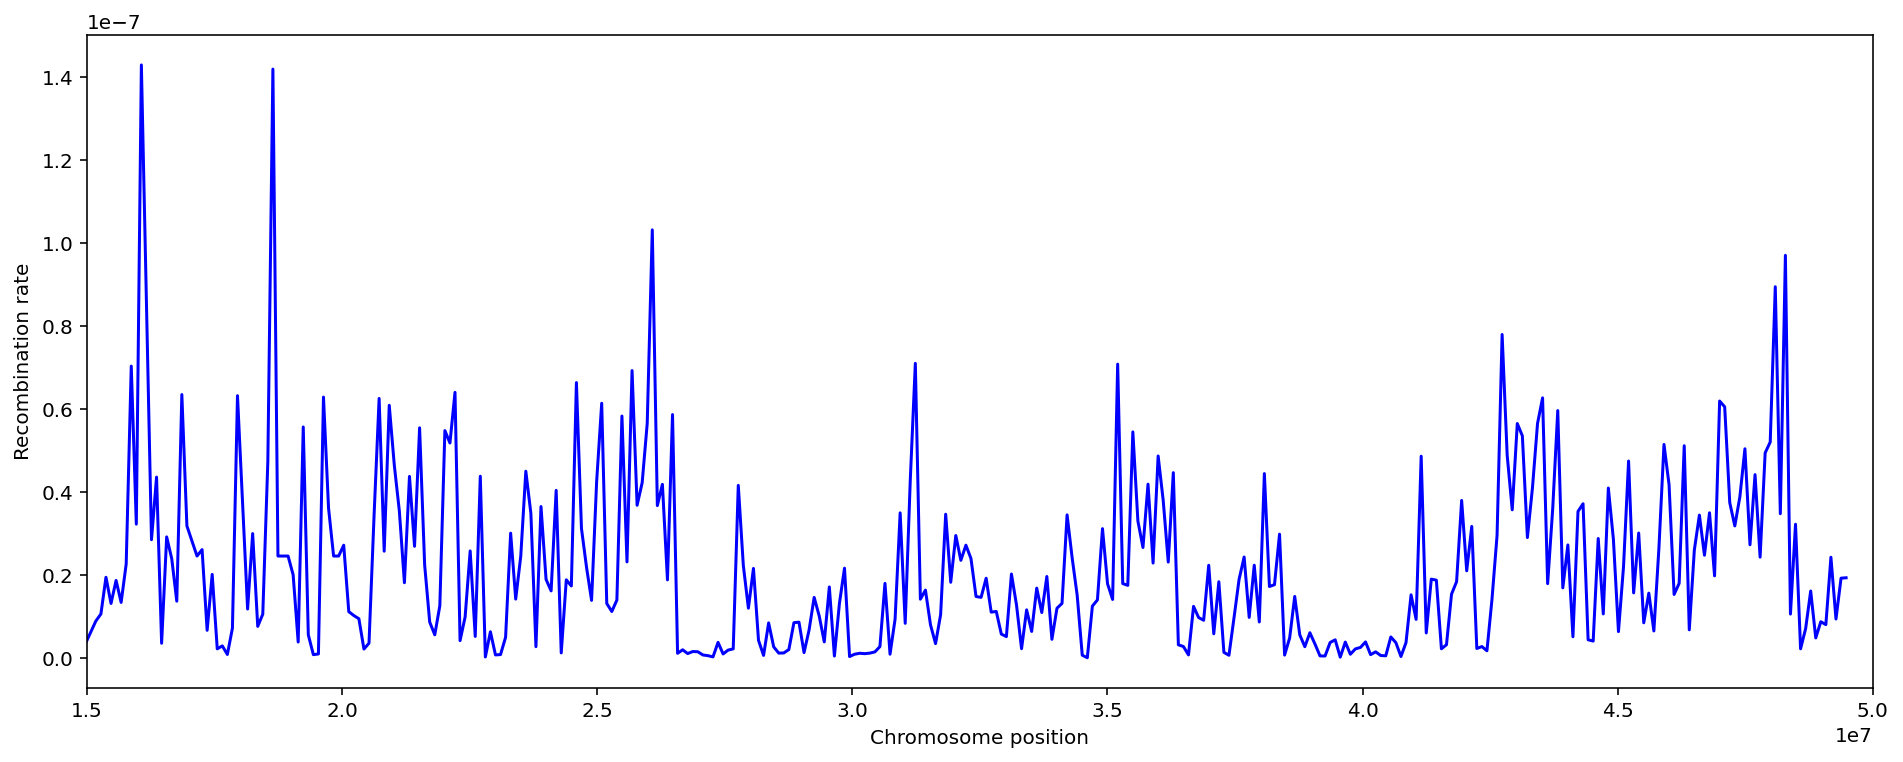

In [88]:
fig, ax = utils.plot_recombination_map(recomb_map)
ax.set_xlim(1.5e7, 5e7)
plt.show()

As we only need to look at a one or a few samples, you can simulate directly using `msprime.simulate`. 

In [156]:
%%time
assumedMu = 1e-8
Ne = 10000 # Human effective population size
params = {'mutation_rate': assumedMu, 'sample_size': 10,
          'Ne': Ne, 'recombination_map': recomb_map}
ts = msprime.simulate(**params)

CPU times: user 41.3 s, sys: 95.6 ms, total: 41.4 s
Wall time: 56.2 s


Split the genotype matrix into windows and use the model to predict the recombination rates and plot the results. You can use the code from the previous section, starting with say 100 windows:

In [175]:
windows = np.arange(0.0, ts.sequence_length, ts.sequence_length / 100)
g = utils.windowedGenotypeMatrixGenerator(ts, batchSize=len(windows), windows=windows, maxlen=1051)

Here you could also try the model with dropout layers (`models/m2.gru.dropout.h5`). Recall that our model `m1` was trained on data with slightly larger $N_e$ and could therefore be prone to overfitting this data. See if there is any difference using model `m2`.

## Try out ReLERNN

Finally, if you feel like it, you can test ReLERNN itself. It comes with an example vcf and pipeline. Clone the repo, cd to `examples` and run the pipeline!


In [92]:
# !git clone git@github.com:kr-colab/ReLERNN.git
# !cd ReLERNN/examples
# !./example_pipeline.sh

## References


Adrion, Jeffrey R., Jared G. Galloway, and Andrew D. Kern. 2020. “Predicting the Landscape of Recombination Using Deep Learning.” Molecular Biology and Evolution 37 (6): 1790–1808. doi:10.1093/molbev/msaa038.

Burri, Reto, Alexander Nater, Takeshi Kawakami, Carina F. Mugal, Pall I. Olason, Linnea Smeds, Alexander Suh, et al. 2015. “Linked Selection and Recombination Rate Variation Drive the Evolution of the Genomic Landscape of Differentiation across the Speciation Continuum of Ficedula Flycatchers.” Genome Research 25 (11): 1656–65. doi:10.1101/gr.196485.115.

Wolf, Jochen B. W., and Hans Ellegren. 2017. “Making Sense of Genomic Islands of Differentiation in Light of Speciation.” Nature Reviews Genetics 18 (2): 87–100. doi:10.1038/nrg.2016.133.
